<a href="https://colab.research.google.com/github/Nateme16/geo-aquawatch-water-quality/blob/main/Solid_Nate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start building SOLID with S2 SR while Acolite version is sorted


In [1]:
!pip install geemap --quiet

     |████████████████████████████████| 1.9 MB 13.5 MB/s 
     |████████████████████████████████| 3.3 MB 34.0 MB/s 
     |████████████████████████████████| 98 kB 7.1 MB/s 
     |████████████████████████████████| 1.2 MB 68.6 MB/s 
     |████████████████████████████████| 95 kB 3.2 MB/s 
     |████████████████████████████████| 8.6 MB 52.1 MB/s 
     |████████████████████████████████| 93 kB 959 kB/s 
     |████████████████████████████████| 219 kB 88.3 MB/s 
     |████████████████████████████████| 1.3 MB 71.3 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 216 kB 72.7 MB/s 
     |████████████████████████████████| 130 kB 84.7 MB/s 
     |████████████████████████████████| 1.7 MB 79.0 MB/s 
     |████████████████████████████████| 97 kB 5.6 MB/s 
     |████████████████████████████████| 428 kB 80.9 MB/s 
     |████████████████████████████████| 396 kB 83.3 MB/s 
     |████████████████████████████████| 60 kB 6.2 MB/s 
     |████████████████████

In [2]:
import geemap

In [3]:
Map = geemap.Map(center=[42,-71], zoom= 9)
Map

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=G3rupJqMmRgXAtlrXrgkLCTgaNfBmGNjXMLVjDBVG8E&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjE5iGXlQEZF8jTBgD-P9Xh0_uFnK15LaymqF8lXmrFAPyNi4URls0

Successfully saved authorization token.


Map(center=[42, -71], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

Get s2 sr imagery for Narragansett Bay region

In [4]:
import ee
NBay = ee.Geometry.Polygon(
        [[[-71.44643316430347, 41.92140472212022],
          [-71.53981695336597, 41.48257061731345],
          [-71.47939214867847, 41.3383770483458],
          [-71.16078863305347, 41.42699101424345],
          [-71.16095830370352, 41.64257191827559],
          [-70.97676763695972, 41.88869830740288],
          [-71.15111544654354, 41.97883748042962]]])

imageVisParam = {"opacity":1,"bands":["B4","B3","B2"],"min":-560.1588934829267,"max":2614.3187289464204,"gamma":1}

In [5]:
area=NBay
#Time window
startyear = 2020
endyear = 2020;
startmonth = 1
endmonth = 12

imageCollection = ee.ImageCollection("COPERNICUS/S2_SR")\
  .filterBounds(area)\
  .filter(ee.Filter.lt('HIGH_PROBA_CLOUDS_PERCENTAGE',10))\
  .filter(ee.Filter.calendarRange(startyear,endyear,'year'))\
  .filter(ee.Filter.calendarRange(startmonth,endmonth,'month'))\
  .sort('system:time_start')\
  .set('SENSOR_ID', 'OLI_TIRS')

#old s2 cloudmask and water, there is a different new one, but keeping it simple
def cloudmask(img):
                  mask = img.select(['SCL']).eq(6)
                  notcloud=img.select(['QA60']).eq(0)
                  img=img.updateMask(mask)
                  img=img.updateMask(notcloud)
                  return img

imageCollection = imageCollection.map(cloudmask)

#Map.addLayer(imageCollection.median(),imageVisParam,"result1")


Keep just one image to learn on and classify the "type" of SOLID water


In [ ]:

#image = ee.Image(imageCollection.sort('HIGH_PROBA_CLOUDS_PERCENTAGE',False).first());



Create water type from band rules from SOLID

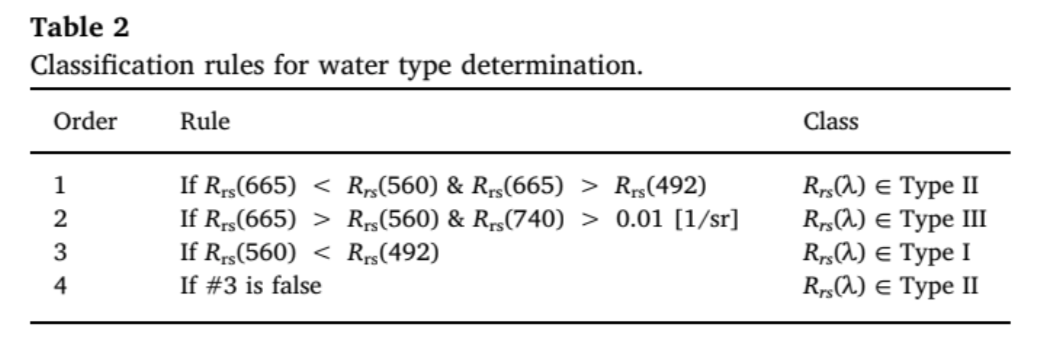


In [6]:
#get same image as Csaba
image= ee.Image('COPERNICUS/S2_SR/20200116T155609_20200116T155605_T18SUJ')
Map.addLayer(image,imageVisParam,"image")


# B4 - R(665)
# B3 - R(560)
# B2 - R(492)
# B6 - R(740)

def watertype(img):  #get some eyes on the sequence of these logics
  b4 = img.select("B4")
  b3 = img.select("B3")
  b2 = img.select("B2")
  b6 = img.select("B6")
  
  typeII = b4.lt(b3).And(b4.gt(b2))
  typeIII= b4.gt(b3).And(b6.gt(.01)).And(typeII.eq(0)) #"sr" part unclear to me?
  typeI = b3.lt(b2).And(typeIII.eq(0)).And(typeII.eq(0))
  typeIV = b3.gte(b2).And(typeI.eq(0)).And(typeII.eq(0)).And(typeIII.eq(0))

  return img.addBands([typeII.rename('typeII'),typeIII.rename('typeIII'),typeI.rename('typeI'),typeIV.rename("typeIV")])

image=watertype(image)

Map.addLayer(image,imageVisParam,"bands+watertype")

image=image.select(["typeII",'typeIII','typeI',"typeIV"])

Map.addLayer(image,[],"watertype")




Ok. Now lets make some functions to run in the various scenarios. Simple ones to start. 

In [41]:
def typeII(img):
  TSS=ee.Number(2)
  return TSS

def typeIII(img):
  TSS=ee.Number(3)
  return TSS

def typeI(img):
  TSS=ee.Number(1)
  return TSS

def typeIV(img):
  TSS=ee.Number(4)
  return TSS

test=typeII(image)
print(test)
#Map.addLayer(test,[],"TSSit1")

ee.Number({
  "constantValue": 2
})


Then lets run the functions over images based on the conditional logic of which function for what pixel..[link text](https://)

In [57]:

def TSSit(img): #this cant be the fastest way to do this, but it could work

  replacementII=typeII(img)
  replacementIII=typeIII(img)
  replacementI=typeI(img)
  replacementIV=typeIV(img)

  TSS = img.where(img.select("typeII"),replacementII)
  TSS = img.where(img.select("typeIII"),replacementIII)
  TSS = img.where(img.select("typeI"), replacementI)
  TSS = img.where(img.select("typeIV"),replacementIV)

  return TSS


test=TSSit(image)

Map.addLayer(test,[],"TSSit")


#hmm maybe more like this 
# Create zones using an expression, display.


zones_exp = nl_2012.expression("(b('stable_lights') > 62) ? 3 "
                               ": (b('stable_lights') > 55) ? 2 "
                               ": (b('stable_lights') > 30) ? 1 "
                               ": 0")

